### Librerías

In [1]:
import unicodedata

import pandas as pd
import numpy as np

### Carga de Datos

In [2]:
df = pd.read_csv("../data/greatest_colombian_business.csv")

print(df.shape)
display(df.head(3))

(40000, 14)


,NIT,RAZÓN SOCIAL,SUPERVISOR,REGIÓN,DEPARTAMENTO DOMICILIO,CIUDAD DOMICILIO,CIIU,MACROSECTOR,INGRESOS OPERACIONALES,GANANCIA (PÉRDIDA),TOTAL ACTIVOS,TOTAL PASIVOS,TOTAL PATRIMONIO,Año de Corte
0,"899,999,068",ECOPETROL S.A,SUPERFINANCIERA,Bogotá - Cundinamarca,BOGOTA D.C.,BOGOTA D.C.-BOGOTA D.C.,610,MINERO,$144.82,$33.41,$216.85,$125.81,$91.03,"2,022"
1,"900,112,515",REFINERIA DE CARTAGENA S.A.S,SUPERSOCIEDADES,Costa Atlántica,BOLIVAR,CARTAGENA-BOLIVAR,"1,921",MANUFACTURA,$27.86,$2.19,$42.84,$16.48,$26.36,"2,022"
2,"830,095,213",ORGANIZACIÓN TERPEL S.A.,SUPERFINANCIERA,Bogotá - Cundinamarca,BOGOTA D.C.,BOGOTA D.C.-BOGOTA D.C.,"4,661",COMERCIO,$23.60,$0.33,$7.48,$4.47,$3.01,"2,022"


### Limpieza de Datos

In [3]:
# Normalizar nombres de columnas

def normalize_column(col):
    # Eliminar acentos
    nfkd_form = unicodedata.normalize('NFKD', col)
    without_accents = "".join([c for c in nfkd_form if not unicodedata.combining(c)])
    # Reemplazar Ñ por N y espacios por _
    return without_accents.replace("Ñ", "N").replace("ñ", "N").replace(" ", "_")#.upper()

df.columns = [normalize_column(c) for c in df.columns]

df.columns

Index(['NIT', 'RAZON_SOCIAL', 'SUPERVISOR', 'REGION', 'DEPARTAMENTO_DOMICILIO',
       'CIUDAD_DOMICILIO', 'CIIU', 'MACROSECTOR', 'INGRESOS_OPERACIONALES',
       'GANANCIA_(PERDIDA)', 'TOTAL_ACTIVOS', 'TOTAL_PASIVOS',
       'TOTAL_PATRIMONIO', 'Ano_de_Corte'],
      dtype='object')

In [4]:
# Limpiar año de corte: "2,022" -> 2022
df["Ano_de_Corte"] = (
    df["Ano_de_Corte"].astype(str).str.replace(",", "", regex=False).astype(int)
)

# Limpiar NIT: quitar comas y espacios, mantener como string
df["NIT"] = df["NIT"].astype(str).str.replace(",", "", regex=False).str.strip()

# Limpiar CIUDAD_DOMICILIO: quitar comas y espacios
df["CIUDAD_DOMICILIO"] = (
    df["CIUDAD_DOMICILIO"]
    .astype(str)
    .str.replace(",", "", regex=False)      # quitar comas
    .str.strip()                            # quitar espacios al inicio/fin
    # .str.replace(r"\s+", " ", regex=True)   # opcional: colapsar espacios múltiples a uno
    .str.replace(r"\s*-\s*", "-", regex=True)  # quitar espacios alrededor de "-"
)

# Eliminar duplicados al final del nombre de la ciudad
def clean_ciudad(ciudad: str) -> str:
    parts = str(ciudad).split("-")
    if len(parts) >= 3 and parts[-1] == parts[-2]:
        parts = parts[:-1]
    return "-".join(parts)
df["CIUDAD_DOMICILIO"] = df["CIUDAD_DOMICILIO"].apply(clean_ciudad)

# Cambiar BOGOTAD.C-BOGOTAD.C.' por 'BOGOTAD.C.-BOGOTAD.C.
df["CIUDAD_DOMICILIO"] = df["CIUDAD_DOMICILIO"].str.replace(
    "BOGOTA D.C-BOGOTA D.C.", "BOGOTA D.C.-BOGOTA D.C.", regex=False
)

In [5]:
# Convertir columnas monetarias a float
money_cols = [
    "INGRESOS_OPERACIONALES",
    "GANANCIA_(PERDIDA)",
    "TOTAL_ACTIVOS",
    "TOTAL_PASIVOS",
    "TOTAL_PATRIMONIO",
]

def clean_money(s):
    return (
        s.astype(str)
         .str.replace("$", "", regex=False)
         .str.replace(",", "", regex=False)
         .str.strip()
         .replace("", np.nan)
         .astype(float)
    )

for col in money_cols:
    df[col] = clean_money(df[col])

df[money_cols].describe(include="all")

,INGRESOS_OPERACIONALES,GANANCIA_(PERDIDA),TOTAL_ACTIVOS,TOTAL_PASIVOS,TOTAL_PATRIMONIO
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,0.167670,0.013160,0.218061,0.110702,0.107080
std,1.392991,0.254042,2.369618,1.345162,1.117528
min,0.010000,-3.210000,0.000000,0.000000,-3.690000
25%,0.030000,0.000000,0.020000,0.010000,0.010000
50%,0.040000,0.000000,0.030000,0.020000,0.010000
75%,0.100000,0.010000,0.090000,0.050000,0.040000
max,144.820000,33.410000,216.850000,130.540000,91.030000


- Podemos observar que la distribución es muy sesgada, puesto que en todas las variables mean << std y p75 << max. Por lo tanto, para nuestros modelos NO vamos a trabajar con los valores crudos, sino casi siempre con: log1p(INGRESOS), log1p(ACTIVOS), etc., y con métricas robustas (mediana, IQR) más que medias.
- Observamos también que la mediana y p25 de GANANCIA_(PERDIDA) son 0. Eso sugiere que más del 50 % de las empresas reportan ganancia≈0 (puede ser redondeo o empresas casi en break-even).
- Además, vemos que en TOTAL_PATRIMONIO el valor de min es -3.69, es decir, hay empresas con patrimonio negativo (lo cual es normal en crisis).

In [6]:
# Recuento de registros por año de corte
print(df["Ano_de_Corte"].value_counts().sort_index())

# Recuento de valores faltantes por columna
df.isna().sum().sort_values(ascending=False)

Ano_de_Corte
2021    10000
2022    10000
2023    10000
2024    10000
Name: count, dtype: int64


RAZON_SOCIAL              2
NIT                       0
SUPERVISOR                0
REGION                    0
DEPARTAMENTO_DOMICILIO    0
CIUDAD_DOMICILIO          0
CIIU                      0
MACROSECTOR               0
INGRESOS_OPERACIONALES    0
GANANCIA_(PERDIDA)        0
TOTAL_ACTIVOS             0
TOTAL_PASIVOS             0
TOTAL_PATRIMONIO          0
Ano_de_Corte              0
dtype: int64

In [7]:
# Número de únicos por columna
df.nunique()

NIT                       13976
RAZON_SOCIAL              18616
SUPERVISOR                    6
REGION                        7
DEPARTAMENTO_DOMICILIO       41
CIUDAD_DOMICILIO            452
CIIU                        418
MACROSECTOR                   6
INGRESOS_OPERACIONALES      454
GANANCIA_(PERDIDA)          210
TOTAL_ACTIVOS               576
TOTAL_PASIVOS               399
TOTAL_PATRIMONIO            490
Ano_de_Corte                  4
dtype: int64

Observamos que hay dos valores faltantes en la RAZON_SOCIAL. Procuraremos imputarlo con otro registro donde para dicho NIT, RAZON_SOCIAL sea no nulo.

In [8]:
# Filas con RAZON_SOCIAL faltante
missing_name = df[df["RAZON_SOCIAL"].isna()]
print("Filas con RAZON_SOCIAL nula:")
display(missing_name[["NIT", "RAZON_SOCIAL", "Ano_de_Corte"]])

# ¿Ese NIT aparece en otras filas con nombre?
for nit in missing_name["NIT"].unique():
    print(f"\nHistórico para NIT {nit}:")
    display(
        df[df["NIT"] == nit][["NIT", "RAZON_SOCIAL", "Ano_de_Corte"]]
        .sort_values("Ano_de_Corte")
        .head(10)
    )

Filas con RAZON_SOCIAL nula:


,NIT,RAZON_SOCIAL,Ano_de_Corte
3532,830065974,NaN,2022
13550,830065974,NaN,2021



Histórico para NIT 830065974:


,NIT,RAZON_SOCIAL,Ano_de_Corte
13550,830065974,NaN,2021
3532,830065974,NaN,2022
24868,830065974,IGT FOREIGN HOLDINGS CORPORATION SUCURSAL COLO...,2023


In [9]:
# Crear un mapa NIT -> nombre más frecuente
name_by_nit = (
    df.dropna(subset=["RAZON_SOCIAL"])
      .groupby("NIT")["RAZON_SOCIAL"]
      .agg(lambda x: x.mode().iat[0])  # modo como nombre canónico
)

# Imputar donde falte
mask_missing_name = df["RAZON_SOCIAL"].isna()
df.loc[mask_missing_name, "RAZON_SOCIAL"] = df.loc[mask_missing_name, "NIT"].map(name_by_nit)

# Ver si todavía queda algo nulo
print("RAZON_SOCIAL nulos luego de imputar:", df["RAZON_SOCIAL"].isna().sum())

# En caso de que haya quedado algo nulo, lo dejamos como "RAZON_DESCONOCIDA"
df["RAZON_SOCIAL"] = df["RAZON_SOCIAL"].fillna("RAZON_DESCONOCIDA")

RAZON_SOCIAL nulos luego de imputar: 0


Verifiquemos que cada NIT tiene máximo un registro por año

In [10]:
dups = df.duplicated(subset=["NIT", "Ano_de_Corte"]).sum()
print("Filas duplicadas NIT-Año:", dups)

Filas duplicadas NIT-Año: 0


Ahora indaguemos si cada NIT está asociado a una única RAZON_SOCIAL.

In [11]:
nit_to_name_counts = (
    df.groupby("NIT")["RAZON_SOCIAL"]
      .nunique()
      .value_counts()
      .sort_index()
)

print("Número de razones sociales distintas por NIT:")
print(nit_to_name_counts)

Número de razones sociales distintas por NIT:
RAZON_SOCIAL
1    9955
2    3393
3     628
Name: count, dtype: int64


In [12]:
nit_multi_name = (
    df.groupby("NIT")["RAZON_SOCIAL"]
      .nunique()
      .reset_index(name="n_names")
      .query("n_names > 1")
)

print("NIT con más de un nombre distinto:")
nit_multi_name

NIT con más de un nombre distinto:


,NIT,n_names
0,800000118,2
2,800000370,2
5,800000946,2
16,800002942,2
19,800003367,2
...,...,...
13884,901538753,2
13896,901550144,2
13904,901555751,2
13959,901675255,2


In [13]:
ejemplo_nit = nit_multi_name["NIT"].iloc[0]
df[df["NIT"] == ejemplo_nit][["NIT", "RAZON_SOCIAL", "Ano_de_Corte"]].drop_duplicates()


,NIT,RAZON_SOCIAL,Ano_de_Corte
2155,800000118,EMPRESA SOCIAL DEL ESTADO HOSPITAL DEPARTAMEN...,2022
11748,800000118,EMPRESA SOCIAL DEL ESTADO HOSPITAL DEPARTAMEN...,2021
22357,800000118,EMPRESA SOCIAL DEL ESTADO HOSPITAL DEPARTAMENT...,2023


De manera similar, veamos si cada RAZON_SOCIAL está asociada a un único NIT o a varios.

In [14]:
name_to_nit_counts = (
    df.groupby("RAZON_SOCIAL")["NIT"]
      .nunique()
      .value_counts()
      .sort_index()
)

print("Número de NIT distintos por RAZON_SOCIAL:")
print(name_to_nit_counts)

Número de NIT distintos por RAZON_SOCIAL:
NIT
1    18607
2        9
Name: count, dtype: int64


In [15]:
name_multi_nit = (
    df.groupby("RAZON_SOCIAL")["NIT"]
      .nunique()
      .reset_index(name="n_nits")
      .query("n_nits > 1")
)

name_multi_nit

,RAZON_SOCIAL,n_nits
376,AGENCIA DE ADUANAS DHL GLOBAL FORWARDING COLOM...,2
1729,AYESA INGENIERIA Y ARQUITECTURA S.A.U SUCURSAL...,2
4785,CONVIAS SAS,2
6353,E.S.E. HOSPITAL SAN RAFAEL,2
6952,EPAM SYSTEMS COLOMBIA S.A.S,2
8692,GRUPO RAMOS CHARRY SAS,2
10160,INTEMPO SAS,2
16689,SUMOTO SA,2
18418,YOYO S.A.S,2


Hacemos limpieza, buscando la razón social canónica por (NIT, CIUDAD_DOMICILIO)

In [16]:
def modo_serie(s):
    m = s.mode()
    if len(m) == 0:
        return np.nan
    return m.iat[0]

# 1) Construimos tabla canónica por (NIT, CIUDAD_DOMICILIO)
canon = (
    df.dropna(subset=["RAZON_SOCIAL"])
      .groupby(["NIT", "CIUDAD_DOMICILIO"])["RAZON_SOCIAL"]
      .agg(modo_serie)
      .reset_index()
      .rename(columns={"RAZON_SOCIAL": "RAZON_SOCIAL_CANONICA"})
)

# 2) Hacemos merge para traer la razón social canónica
df = df.merge(
    canon,
    on=["NIT", "CIUDAD_DOMICILIO"],
    how="left",
)

# 3) Si quieres sustituir completamente RAZON_SOCIAL por la versión canónica:
df["RAZON_SOCIAL"] = df["RAZON_SOCIAL_CANONICA"]
df.drop(columns=["RAZON_SOCIAL_CANONICA"], inplace=True)

# 4) Verificar que no queden nulos
print("RAZON_SOCIAL nulos luego del proceso:", df["RAZON_SOCIAL"].isna().sum())

RAZON_SOCIAL nulos luego del proceso: 0


### Análisis

In [17]:
for col in money_cols:
    zeros = (df[col] == 0).mean()
    negs = (df[col] < 0).mean()
    print(f"{col}: %0 = {zeros:.3f}, %<0 = {negs:.3f}")


INGRESOS_OPERACIONALES: %0 = 0.000, %<0 = 0.000
GANANCIA_(PERDIDA): %0 = 0.705, %<0 = 0.043
TOTAL_ACTIVOS: %0 = 0.028, %<0 = 0.000
TOTAL_PASIVOS: %0 = 0.152, %<0 = 0.000
TOTAL_PATRIMONIO: %0 = 0.202, %<0 = 0.015


In [18]:
mask_all_zero = (
    (df["INGRESOS_OPERACIONALES"] == 0) &
    (df["TOTAL_ACTIVOS"] == 0) &
    (df["TOTAL_PASIVOS"] == 0) &
    (df["TOTAL_PATRIMONIO"] == 0)
)

print("Filas con TODO en 0:", mask_all_zero.sum())
df[mask_all_zero].head()


Filas con TODO en 0: 0


,NIT,RAZON_SOCIAL,SUPERVISOR,REGION,DEPARTAMENTO_DOMICILIO,CIUDAD_DOMICILIO,CIIU,MACROSECTOR,INGRESOS_OPERACIONALES,GANANCIA_(PERDIDA),TOTAL_ACTIVOS,TOTAL_PASIVOS,TOTAL_PATRIMONIO,Ano_de_Corte


In [19]:
df_eda = df.copy()

for col in ["INGRESOS_OPERACIONALES", "TOTAL_ACTIVOS", "TOTAL_PASIVOS", "TOTAL_PATRIMONIO"]:
    df_eda[f"log1p_{col}"] = np.log1p(df_eda[col].clip(lower=0))  # para evitar negativos

df_eda[[f"log1p_{c}" for c in ["INGRESOS_OPERACIONALES", "TOTAL_ACTIVOS"]]].describe()

,log1p_INGRESOS_OPERACIONALES,log1p_TOTAL_ACTIVOS
count,40000.000000,40000.000000
mean,0.106363,0.110421
std,0.214558,0.262621
min,0.009950,0.000000
25%,0.029559,0.019803
50%,0.039221,0.029559
75%,0.095310,0.086178
max,4.982373,5.383807


In [20]:
# Distribución de cantidad de años por NIT
years_per_nit = (
    df.groupby("NIT")["Ano_de_Corte"]
      .nunique()
      .value_counts()
      .sort_index()
)

print("Años distintos por NIT -> número de empresas")
print(years_per_nit)


Años distintos por NIT -> número de empresas
Ano_de_Corte
1    2950
2    2584
3    1886
4    6556
Name: count, dtype: int64


In [21]:
# Crear ratios financieros básicos (con divisiones seguras)
df["margen"] = np.where(
    df["INGRESOS_OPERACIONALES"] > 0,
    df["GANANCIA_(PERDIDA)"] / df["INGRESOS_OPERACIONALES"],
    np.nan,
)

df["roa"] = np.where(
    df["TOTAL_ACTIVOS"] > 0,
    df["GANANCIA_(PERDIDA)"] / df["TOTAL_ACTIVOS"],
    np.nan,
)

df["roe"] = np.where(
    df["TOTAL_PATRIMONIO"] > 0,
    df["GANANCIA_(PERDIDA)"] / df["TOTAL_PATRIMONIO"],
    np.nan,
)

df["leverage"] = np.where(
    df["TOTAL_ACTIVOS"] > 0,
    df["TOTAL_PASIVOS"] / df["TOTAL_ACTIVOS"],
    np.nan,
)

# Indicadores útiles para el modelo más adelante
df["ganancia_positiva"] = (df["GANANCIA_(PERDIDA)"] > 0).astype(int)
df["patrimonio_no_positivo"] = (df["TOTAL_PATRIMONIO"] <= 0).astype(int)


In [22]:
# Resumen por año (numérico)
summary_year = (
    df.groupby("Ano_de_Corte")[
        [
            "INGRESOS_OPERACIONALES",
            "GANANCIA_(PERDIDA)",
            "TOTAL_ACTIVOS",
            "margen",
            "roa",
            "roe",
            "leverage",
        ]
    ]
    .agg(["median", "mean", "std", "quantile"])
)

# Si quantile te da problemas, usa algo más controlado:
summary_year = (
    df.groupby("Ano_de_Corte")[
        [
            "INGRESOS_OPERACIONALES",
            "GANANCIA_(PERDIDA)",
            "TOTAL_ACTIVOS",
            "margen",
            "roa",
            "roe",
            "leverage",
        ]
    ]
    .agg(["median", "mean"])
)

summary_year


INGRESOS_OPERACIONALES           GANANCIA_(PERDIDA)            \
                             median      mean             median      mean   
Ano_de_Corte                                                                 
2021                           0.03  0.130635                0.0  0.011835   
2022                           0.04  0.172758                0.0  0.016621   
2023                           0.05  0.190872                0.0  0.012566   
2024                           0.05  0.176413                0.0  0.011618   

             TOTAL_ACTIVOS           margen              roa              roe  \
                    median      mean median      mean median      mean median   
Ano_de_Corte                                                                    
2021                  0.03  0.180813    0.0  0.049527    0.0  0.035234    0.0   
2022                  0.03  0.215273    0.0  0.056132    0.0  0.039600    0.0   
2023                  0.04  0.230338    0.0  0.041142    0.0  0.031663    0.0   
2024                  0.04  0.245821    0.0  0.042839    0.0  0.032276    0.0   

                       leverage            
                  mean   median      mean  
Ano_de_Corte                               
2021          0.086557      0.5  0.532479  
2022          0.101362      0.5  0.566281  
2023          0.077664      0.5  0.561100  
2024          0.073790      0.5  0.550334

In [23]:
# Resumen por macro sector y año (muy útil para el dashboard luego)
sector_year = (
    df.groupby(["Ano_de_Corte", "MACROSECTOR"])[
        ["GANANCIA_(PERDIDA)", "margen", "roa", "roe"]
    ]
    .median()
    .reset_index()
)

sector_year.head()

,Ano_de_Corte,MACROSECTOR,GANANCIA_(PERDIDA),margen,roa,roe
0,2021,AGROPECUARIO,0.0,0.0,0.0,0.0
1,2021,COMERCIO,0.0,0.0,0.0,0.0
2,2021,CONSTRUCCIÓN,0.0,0.0,0.0,0.0
3,2021,MANUFACTURA,0.0,0.0,0.0,0.0
4,2021,MINERO,0.0,-0.0,0.0,-0.0


In [24]:
top_sectores_por_ano = (
    sector_year.sort_values(
        by=["Ano_de_Corte", "GANANCIA_(PERDIDA)"],
        ascending=[True, False]
    )
)

top_sectores_por_ano.head(20)

,Ano_de_Corte,MACROSECTOR,GANANCIA_(PERDIDA),margen,roa,roe
0,2021,AGROPECUARIO,0.00,0.000000,0.000000,0.000000
1,2021,COMERCIO,0.00,0.000000,0.000000,0.000000
2,2021,CONSTRUCCIÓN,0.00,0.000000,0.000000,0.000000
3,2021,MANUFACTURA,0.00,0.000000,0.000000,0.000000
4,2021,MINERO,0.00,-0.000000,0.000000,-0.000000
5,2021,SERVICIOS,0.00,0.000000,0.000000,0.000000
10,2022,MINERO,0.01,0.057190,0.052139,0.111111
6,2022,AGROPECUARIO,0.00,0.000000,0.000000,0.000000
7,2022,COMERCIO,0.00,0.000000,0.000000,0.000000
8,2022,CONSTRUCCIÓN,0.00,0.000000,0.000000,0.000000


<Figure size 640x480 with 0 Axes>

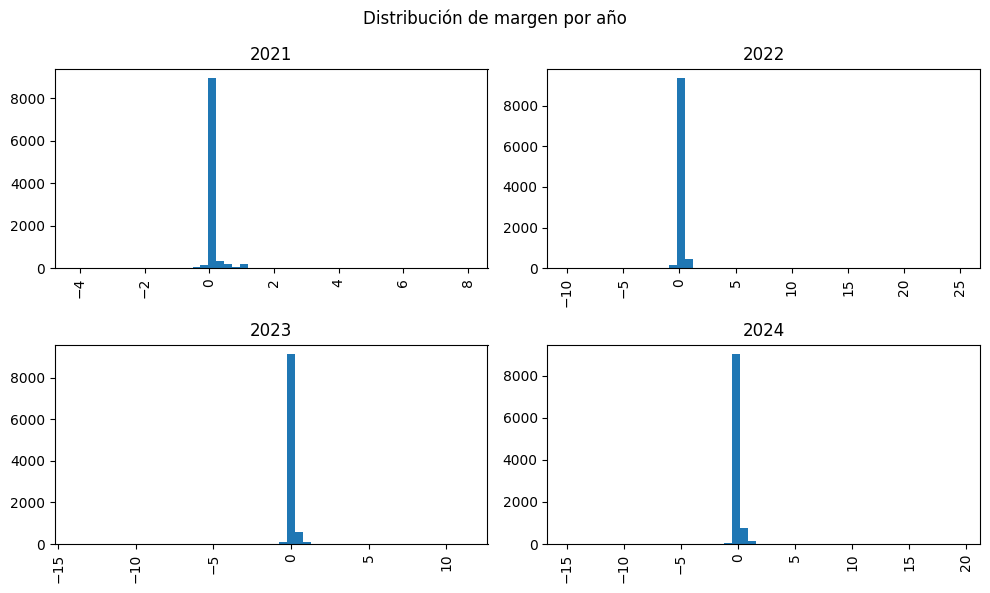

In [25]:
import matplotlib.pyplot as plt

plt.figure()
df.hist(
    column="margen",
    by="Ano_de_Corte",
    bins=50,
    figsize=(10, 6),
)
plt.suptitle("Distribución de margen por año")
plt.tight_layout()
plt.show()
